# Homework 3
Pedro Augusto Januzzi Guerra

In [4]:
using Parameters, LinearAlgebra, Dierckx, FastChebInterp, Plots, Roots, BenchmarkTools, PrettyTables,ImageView, Images

## Question (1)

For linear and cubic interpolation I use the built-in function `Spline1D` that is part of the `Dierckx` package, as they handle arbitrary "data" points and also give us freedom to assign boundary conditions and smoothing parameters when relevant. Unfortunately it does not allow us to use the derivative of an arbitrary utility function and use it as a boundary condition. However, as I have not found another package that allows me to do so and since I do not use this technique in this homework, I proceed with `Spline1D`.  For Chebyshev polynomial interpolation, I use the package `FastChebInterp`.

Utility functions:

In [5]:
u1(c) = log.(c);
u2(c) = sqrt.(c);
u3(α,c) = c.^(1-α)./(1-α); # α ∈ {2,5,10}

To get familiar with the problem, I start with $u(c) = \log(c)$ and a simple linearly spaced grid. I know this isn't a good choice, but I just want to understand what the computer is doing. 

Set up a grid for $c$:

In [6]:
pts = 100; # number of points
c_grid = LinRange(0.1,5,pts);
linear_approx = Spline1D(c_grid,u1(c_grid),k=1) # k = 1 sets linear interpolation
cubic_approx = Spline1D(c_grid,u1(c_grid),k=3) # k = 3 sets cubic interpolation 
cheb_approx = chebinterp(u1.(chebpoints(pts, c_grid[1], c_grid[end])),c_grid[1],c_grid[end])

ChebPoly{1,Float64,Float64} order (100,) polynomial on [0.1,5.0]

Plot graphs:

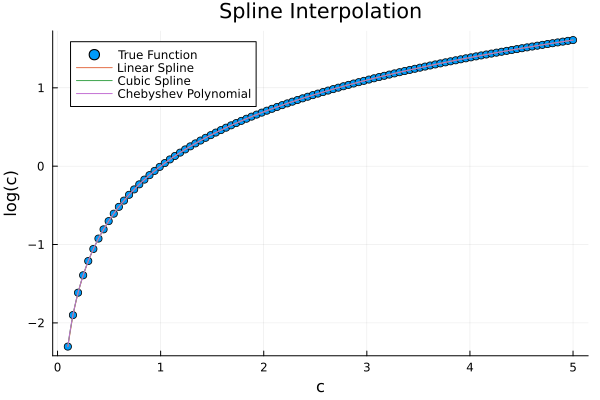

In [7]:
scatter(c_grid,u1(c_grid),label="True Function",xlabel="c",ylabel="log(c)",title="Spline Interpolation",lw=2)
cfine = 0.1:0.01:5 # 0.01 increment
plot!(cfine,linear_approx(cfine),label="Linear Spline")
plot!(cfine,cubic_approx(cfine),label="Cubic Spline")
plot!(cfine,cheb_approx.(cfine),label="Chebyshev Polynomial")

Zooming in:

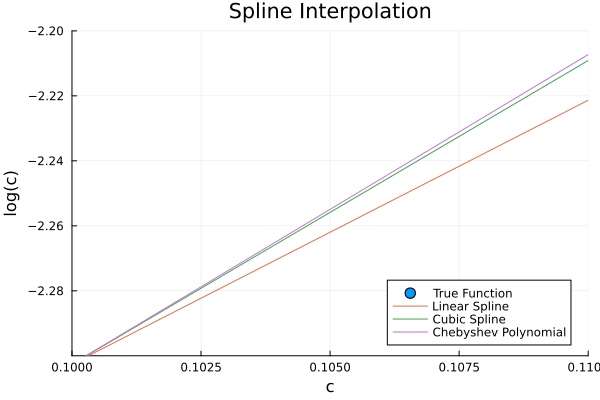

In [8]:
scatter(c_grid,u1(c_grid),label="True Function",xlabel="c",ylabel="log(c)",title="Spline Interpolation",lw=2)
cfine = 0.1:0.01:5
plot!(cfine,linear_approx(cfine),label="Linear Spline",xlim=[0.1,0.11],ylim=[-2.3,-2.2])
plot!(cfine,cubic_approx(cfine),label="Cubic Spline")
plot!(cfine,cheb_approx.(cfine),label="Chebyshev Polynomial")
plot!(legend = :bottomright)

Now I move to the question. 

### Item (a)

Create a function for the expanding grid:

In [9]:
function expanding_grid(lb,ub,pts,θ) #lb=lower bound,ub=upper bound,pts=number of points,θ=expansion factor
    # Step 1: create an equally-spaced grid between 0 and 1
    grid = LinRange(0,1,pts+1)
    # Step 2: expand the grid
    grid = grid.^θ
    # Step 3: shift and scale the grid to cover the interval [lb,ub]
    grid = lb .+ (ub-lb).*grid
    
    return grid
end

expanding_grid (generic function with 1 method)

I start with $u(c) = \log(c)$ and 50 grid points:

In [10]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 50
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

Visualize grids:

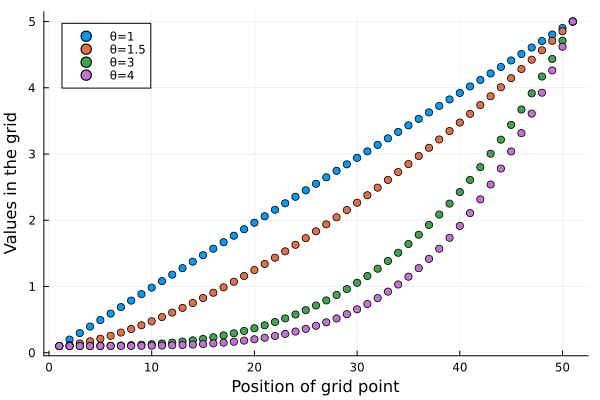

In [11]:
scatter(grids[1,:], label="θ=1",ylabel = "Values in the grid",xlabel="Position of grid point")
scatter!(grids[2,:], label="θ=1.5")
scatter!(grids[3,:], label="θ=3")
scatter!(grids[4,:], label="θ=4")

Interpolate utility function using (i) linear interpolation, (ii) cubic spline, and (iii) Chebyshev polynomials:

In [12]:
# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u1(grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u1(grids[i,:]),k=3)
end
# Since the lower and upper bounds of all grids are the same, θ does not affect Cheb Interpolation
cheb_interp =  chebinterp(u1.(chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (51,) polynomial on [0.1,5.0]

Plot graphs for linear interpolation:

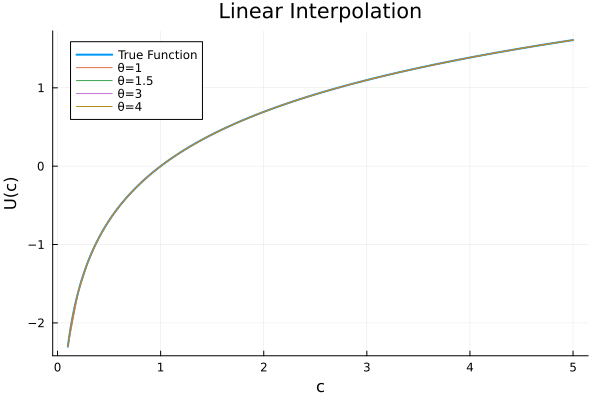

In [13]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

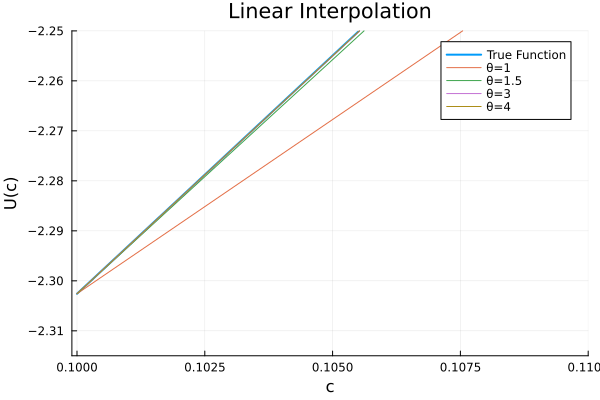

In [14]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(xlim=[0.0999,0.11],ylim=[-2.315,-2.25])
plot!(legend = :topright)

Plot graphs for cubic spline:

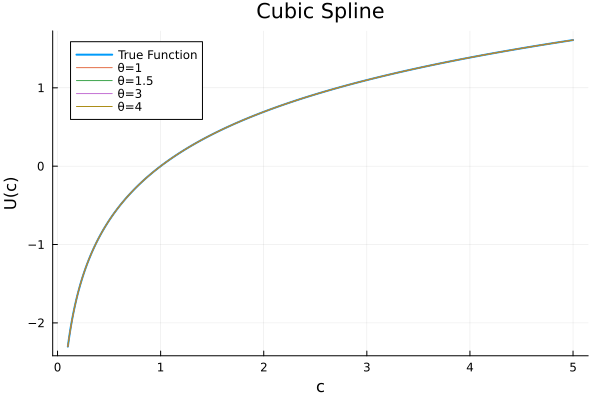

In [15]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

Zooming in:

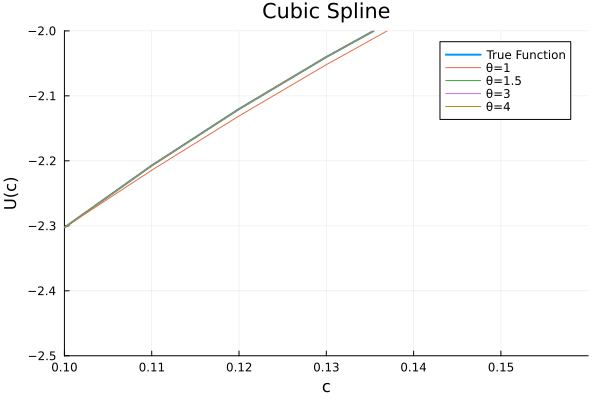

In [16]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(xlim=[0.1,0.16],ylim=[-2.5,-2])
plot!(legend = :topright)

Plot graphs for Chebyshev polynomial:

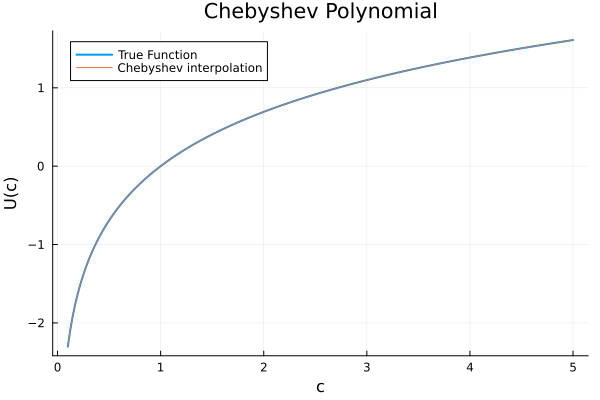

In [17]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Polynomial",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev interpolation")

Zooming in:

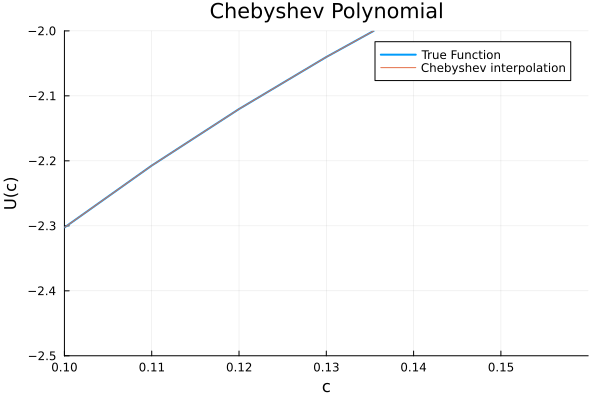

In [18]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Polynomial",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev interpolation")
plot!(xlim=[0.1,0.16],ylim=[-2.5,-2])
plot!(legend = :topright)

I now compute the sup norm of the difference between each interpolation schemes and the true utility values.

$θ=1$:

In [19]:
diff_linear = norm(linear_interp[1](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.05765719796552138
Error of cubic interpolation:0.011822763276748471
Error of Chebyshev interpolation:6.210384673188685e-8


$\theta = 1.5$:

In [20]:
diff_linear = norm(linear_interp[2](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.00517424586837234
Error of cubic interpolation:6.177444122279496e-5
Error of Chebyshev interpolation:6.210384673188685e-8


$\theta = 3$:

In [21]:
diff_linear = norm(linear_interp[3](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0016846605481126709
Error of cubic interpolation:2.824281206459389e-6
Error of Chebyshev interpolation:6.210384673188685e-8


$\theta=4$:

In [22]:
diff_linear = norm(linear_interp[4](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0018061854644271236
Error of cubic interpolation:7.344188504898597e-6
Error of Chebyshev interpolation:6.210384673188685e-8


A few things worth noting:

1. Chebyshev polynomial interpolation outperformed cubic spline interpolation, which in turn outperformed linear interpolation for all values of $\theta$.
2. Increasing $\theta$ from 1 to 1.5 and 3 improved the performance of all interpolation schemes.
3. However, linear interpolation and cubic spline performed better when $\theta = 3$ than when $\theta = 4$.


The better performance of Chebyshev polynomials is not surprising, as they are designed to minimize maximum deviations. Moreover, note that the error for Chebyshev polynomials does not change, as this interpolation method depends only on the lowest and highest grid values, which do not change with $\theta$.

Now I redo this analysis, but using 100 grid points:

In [23]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 100
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

In [24]:
# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u1(grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u1(grids[i,:]),k=3)
end
cheb_interp =  chebinterp(u1.(chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (101,) polynomial on [0.1,5.0]

Linear interpolation:

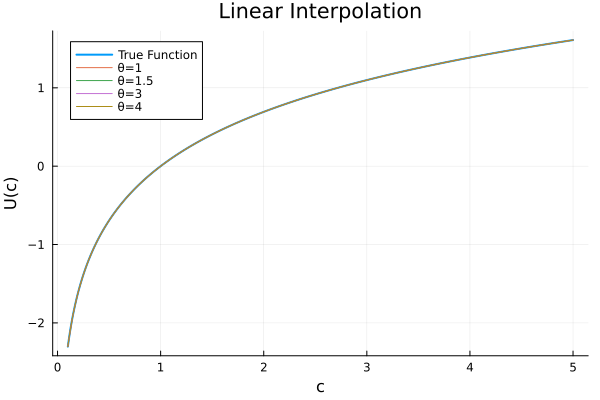

In [25]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

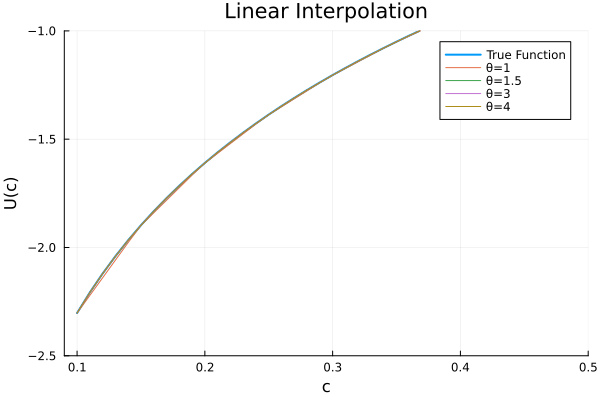

In [26]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(ylim=[-2.5,-1],xlim=[0.09,0.5])

Cubic spline:

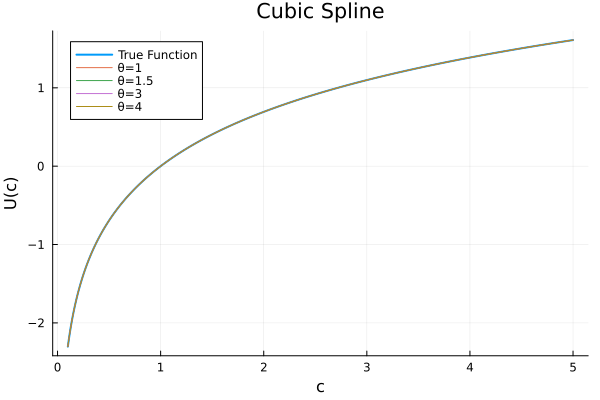

In [27]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

Zooming in:

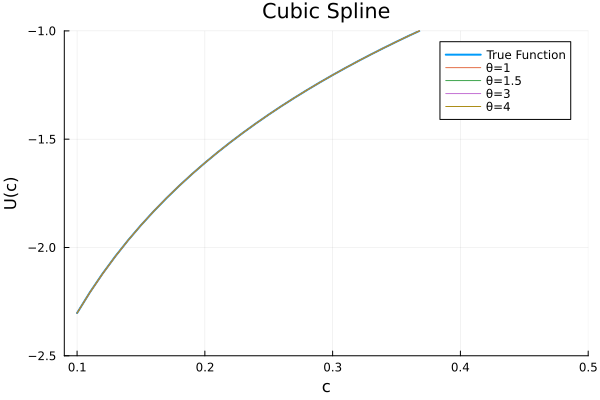

In [28]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(ylim=[-2.5,-1],xlim=[0.09,0.5])

Chebyshev polynomials:

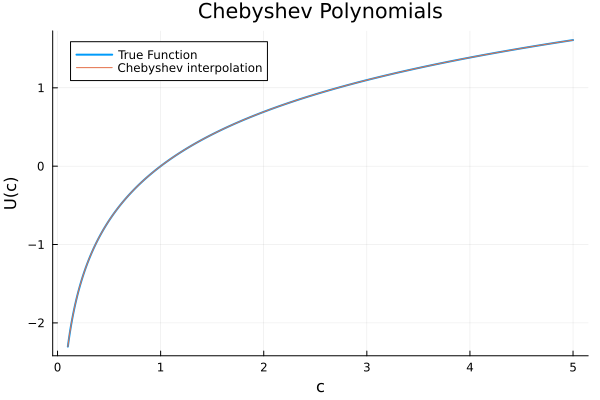

In [29]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Polynomials",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev interpolation")

Zooming in:

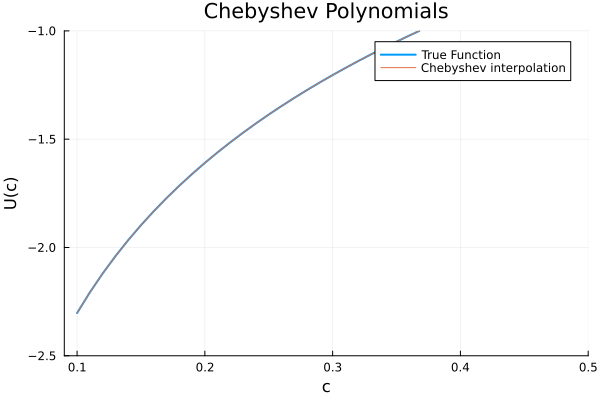

In [30]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u1(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Polynomials",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev interpolation")
plot!(ylim=[-2.5,-1],xlim=[0.09,0.5])

Compute errors measured by the sup norm.

$\theta=1$:

In [31]:
diff_linear = norm(linear_interp[1](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.019555793546049305
Error of cubic interpolation:0.002006008074137089
Error of Chebyshev interpolation:2.020605904817785e-14


$\theta=1.5$:

In [32]:
diff_linear = norm(linear_interp[2](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0013128907589272654
Error of cubic interpolation:1.673120076928214e-6
Error of Chebyshev interpolation:2.020605904817785e-14


$\theta = 3$:

In [33]:
diff_linear = norm(linear_interp[3](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0004182506218812776
Error of cubic interpolation:1.7566943766311738e-7
Error of Chebyshev interpolation:2.020605904817785e-14


$\theta=4$:

In [34]:
diff_linear = norm(linear_interp[4](cfine) - u1(cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u1(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u1(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.00045059272522274263
Error of cubic interpolation:4.2855821180687315e-7
Error of Chebyshev interpolation:2.020605904817785e-14


Now I will move the utility function of the form $u(c) = \sqrt{c}$. I will use 100 grid points.

In [35]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 100
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u2(grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u2(grids[i,:]),k=3)
end
cheb_interp =  chebinterp(u2.(chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (100,) polynomial on [0.1,5.0]

Linear interpolation:

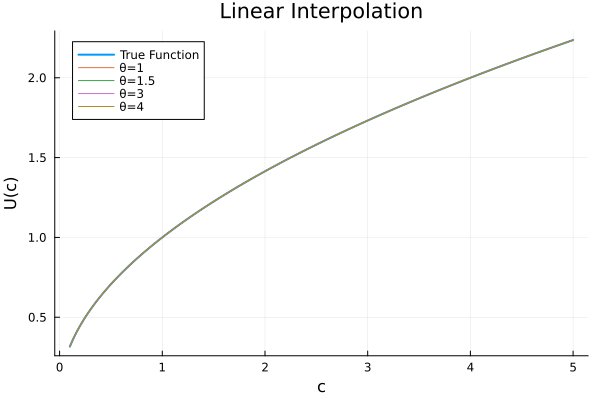

In [36]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

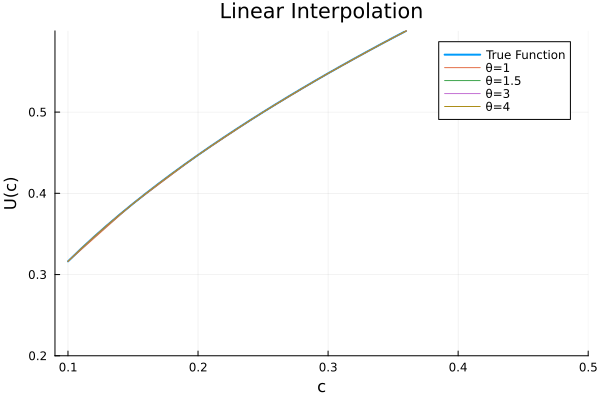

In [37]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(ylim=[0.2,0.6],xlim=[0.09,0.5])

Cubic interpolation:

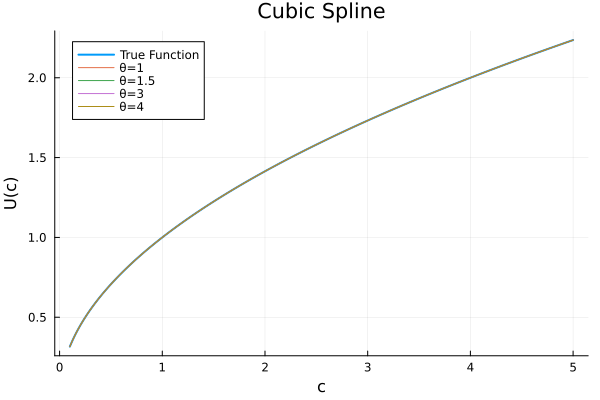

In [38]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

Zooming in:

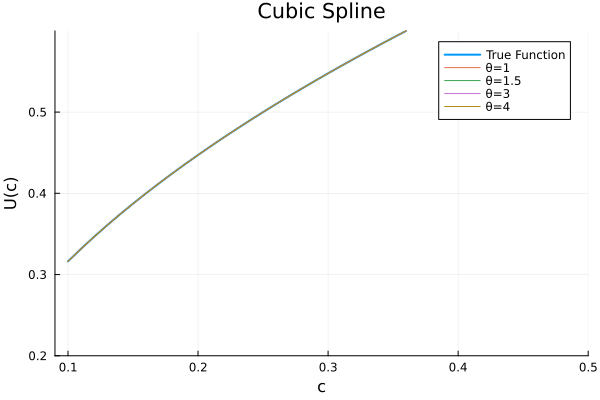

In [39]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(ylim=[0.2,0.6],xlim=[0.09,0.5])

Chebyshev interpolation:

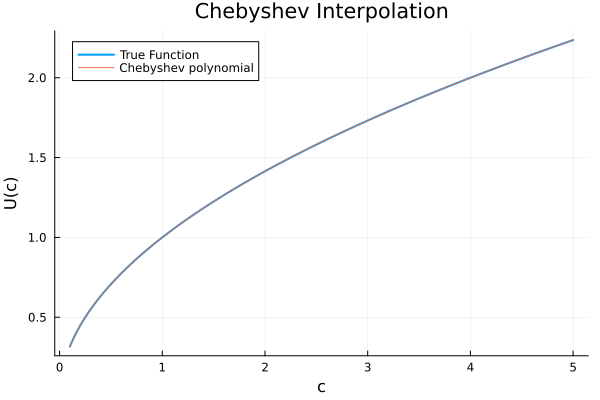

In [40]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")

Zooming in:

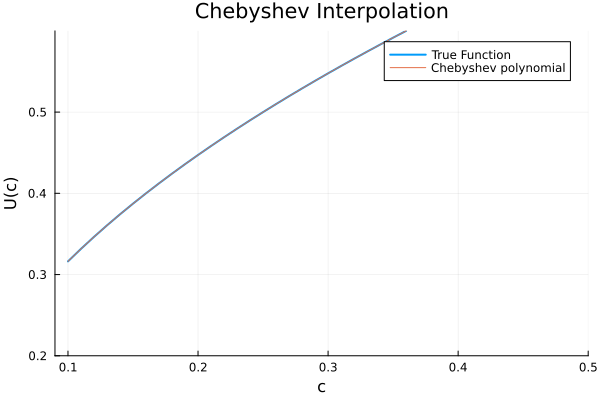

In [41]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u2(cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")
plot!(ylim=[0.2,0.6],xlim=[0.09,0.5])

Compute the error using the sup norm.

$\theta=1$:

In [42]:
diff_linear = norm(linear_interp[1](cfine) - u2(cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u2(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u2(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0017018178252895533
Error of cubic interpolation:0.00011970569505892481
Error of Chebyshev interpolation:1.5543122344752192e-15


$\theta=1.5$:

In [43]:
diff_linear = norm(linear_interp[2](cfine) - u2(cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u2(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u2(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.00014012826414627755
Error of cubic interpolation:1.1231486657381495e-7
Error of Chebyshev interpolation:1.5543122344752192e-15


$\theta=3$:

In [44]:
diff_linear = norm(linear_interp[3](cfine) - u2(cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u2(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u2(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:7.052203954038827e-5
Error of cubic interpolation:4.6122627939126914e-8
Error of Chebyshev interpolation:1.5543122344752192e-15


$\theta=4$:

In [45]:
diff_linear = norm(linear_interp[4](cfine) - u2(cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u2(cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u2(cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.00010720528706187338
Error of cubic interpolation:1.46723103444657e-7
Error of Chebyshev interpolation:1.5543122344752192e-15


I now move to the CRRA utility. I start with $\alpha=2$ and use 100 grid points:

In [46]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 100
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

α = 2;

# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=3)
end
cheb_interp =  chebinterp(u3.(α,chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (101,) polynomial on [0.1,5.0]

Linear interpolation:

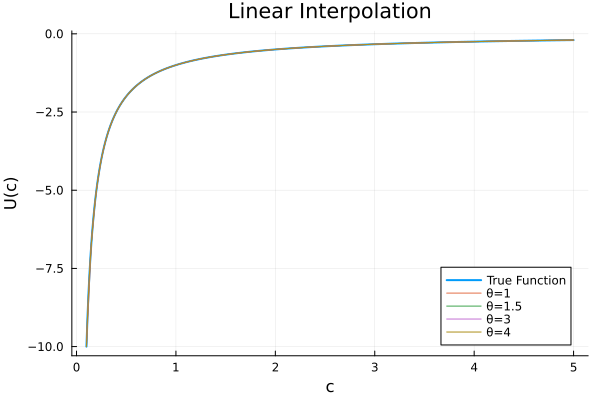

In [47]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

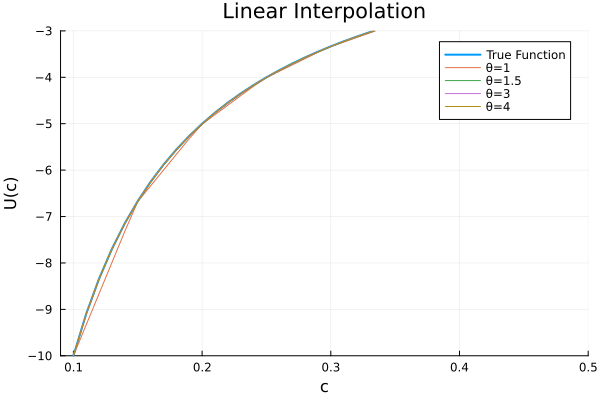

In [48]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(ylim=[-10,-3],xlim=[0.09,0.5])

Cubic interpolation:

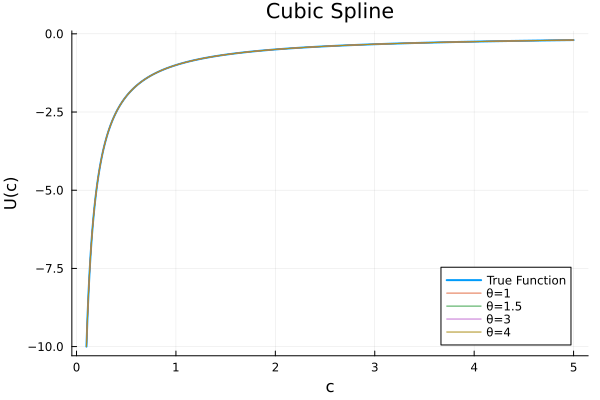

In [49]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

Zooming in:

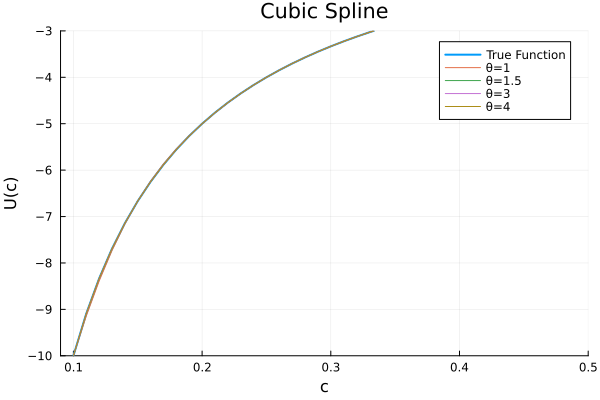

In [50]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(ylim=[-10,-3],xlim=[0.09,0.5])

Chebyshev polynomials:

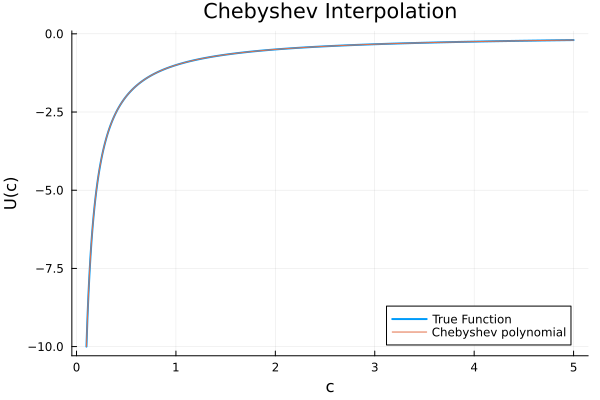

In [51]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")

Zooming in:

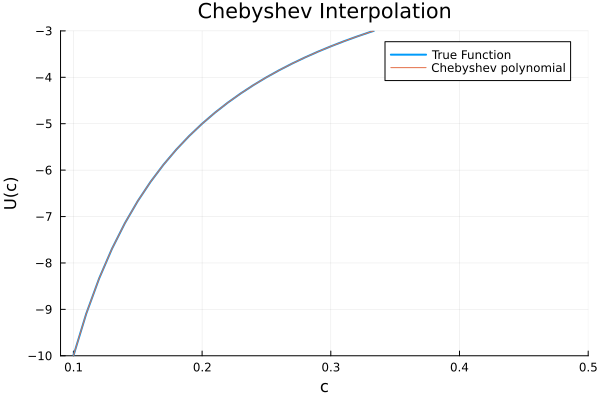

In [52]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")
plot!(ylim=[-10,-3],xlim=[0.09,0.5])

Compute errors using the sup norm.

$\theta=1$:

In [53]:
diff_linear = norm(linear_interp[1](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.32438478747203625
Error of cubic interpolation:0.05546755050185581
Error of Chebyshev interpolation:3.12105896682624e-12


$\theta=1.5$:

In [54]:
diff_linear = norm(linear_interp[2](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.01956335144746113
Error of cubic interpolation:6.11926863616219e-5
Error of Chebyshev interpolation:3.12105896682624e-12


$\theta=3$:

In [55]:
diff_linear = norm(linear_interp[3](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.003598350672062267
Error of cubic interpolation:2.7222975278462513e-6
Error of Chebyshev interpolation:3.12105896682624e-12


$\theta=4$:

In [56]:
diff_linear = norm(linear_interp[4](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:0.0034142405899943995
Error of cubic interpolation:2.7013743602033458e-6
Error of Chebyshev interpolation:3.12105896682624e-12


Now I do the same for $\alpha=5$:

In [57]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 100
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

α = 5;

# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=3)
end
cheb_interp =  chebinterp(u3.(α,chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (101,) polynomial on [0.1,5.0]

Linear interpolation:

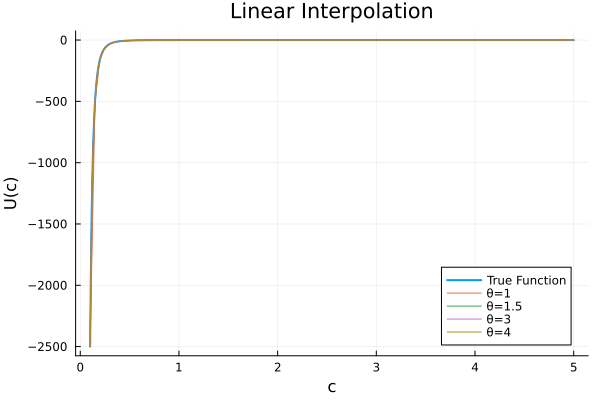

In [58]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

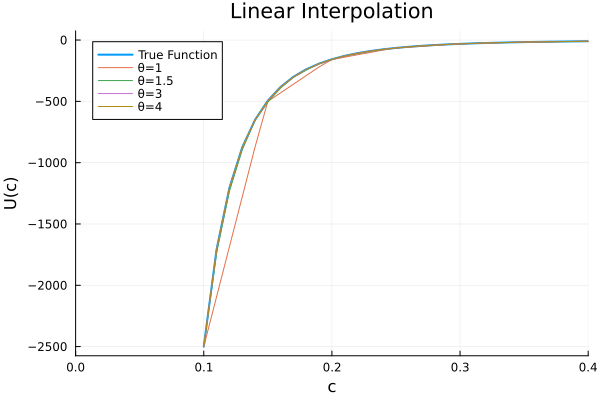

In [59]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(xlim=[0,0.4])

Cubic interpolation:

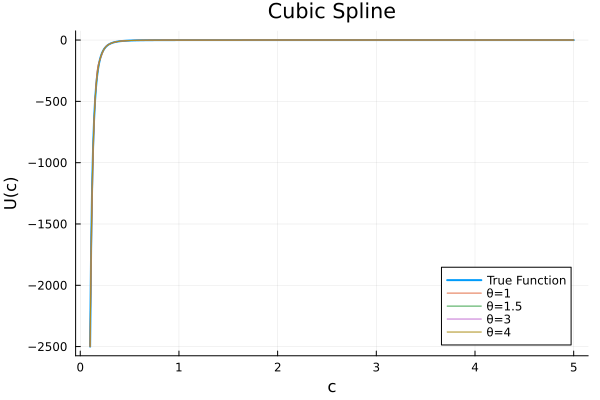

In [60]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

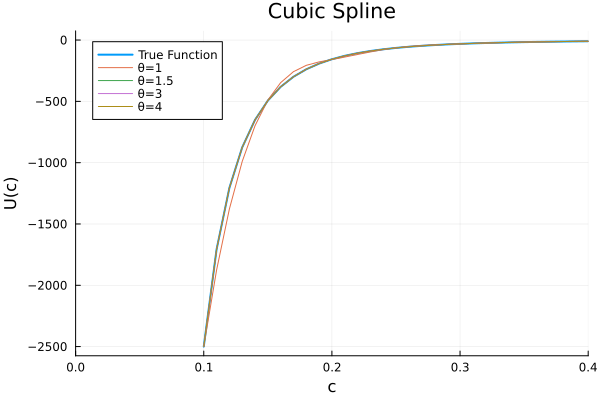

In [61]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(xlim=[0,0.4])

Chebyshev interpolation:

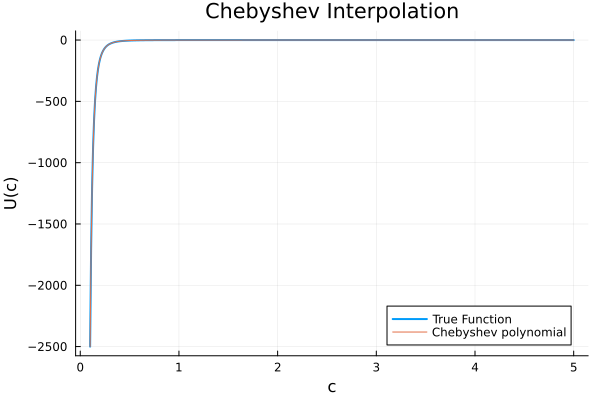

In [62]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")

Zooming in:

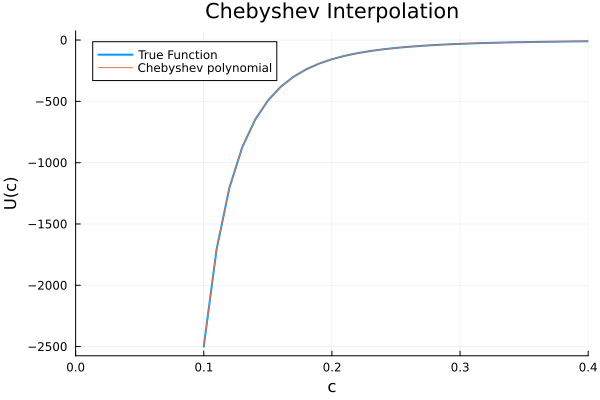

In [63]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")
plot!(xlim=[0,0.4])

Compute errors using the sup norm:

$\theta=1$:

In [64]:
diff_linear = norm(linear_interp[1](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:480.98700819707415
Error of cubic interpolation:172.08609505014238
Error of Chebyshev interpolation:5.115825842949562e-7


$\theta=1.5$:

In [65]:
diff_linear = norm(linear_interp[2](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:28.63282004788516
Error of cubic interpolation:0.45597678960257326
Error of Chebyshev interpolation:5.115825842949562e-7


$\theta=3$:

In [66]:
diff_linear = norm(linear_interp[3](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:2.576168596909156
Error of cubic interpolation:0.003771251030627809
Error of Chebyshev interpolation:5.115825842949562e-7


$\theta=4$:

In [67]:
diff_linear = norm(linear_interp[4](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:1.6787694158272188
Error of cubic interpolation:0.003299712890338924
Error of Chebyshev interpolation:5.115825842949562e-7


As expected, given the same number of grid points and the same values for $\theta$, the polynomial approximations perform worse for higher values of relative risk aversion. To examine this effect further, we increase $\alpha$ to 10.


In [121]:
# vector with θ values 
θ_vec = [1, 1.5, 3, 4]
# number of grid points 
pts = 100
# initialize a matrix that will store the grids for each θ value  
grids = Matrix{Float64}(undef, 4, pts+1)
# bounds of the grids 
lb = 0.1
ub = 5
# compute the grids for each value of θ 
for i = 1:length(θ_vec)
    grids[i,:] = expanding_grid(lb,ub,pts,θ_vec[i])
end

α = 10;

# Initilize splines for all possible values of θ
linear_interp = Vector{Spline1D}(undef, length(θ_vec))
cubic_interp = Vector{Spline1D}(undef, length(θ_vec))
cheb_interp = Vector{FastChebInterp.ChebPoly{1, Float64, Float64}}(undef, 1)
for i =1:4
    linear_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=1)
    cubic_interp[i] =  Spline1D(grids[i,:],u3(α,grids[i,:]),k=3)
end
cheb_interp =  chebinterp(u3.(α,chebpoints(pts+1, grids[1,1], grids[1,end])),grids[1,1],grids[1,end])

ChebPoly{1,Float64,Float64} order (101,) polynomial on [0.1,5.0]

Linear interpolation:

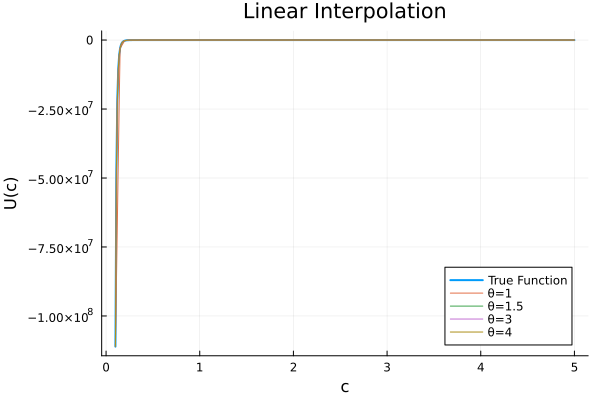

In [69]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")

Zooming in:

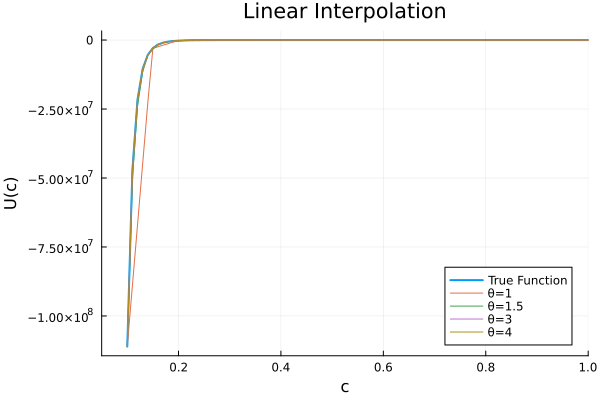

In [70]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Linear Interpolation",lw=2)
plot!(cfine,linear_interp[1](cfine),label="θ=1")
plot!(cfine,linear_interp[2](cfine),label="θ=1.5")
plot!(cfine,linear_interp[3](cfine),label="θ=3")
plot!(cfine,linear_interp[4](cfine),label="θ=4")
plot!(xlim=[0.05,1])

Cubic interpolation:

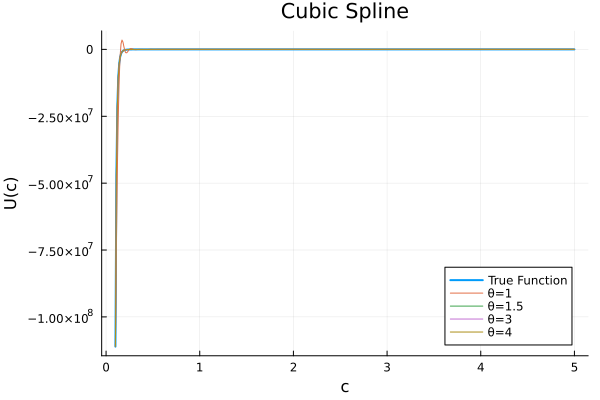

In [71]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")

Zooming in:

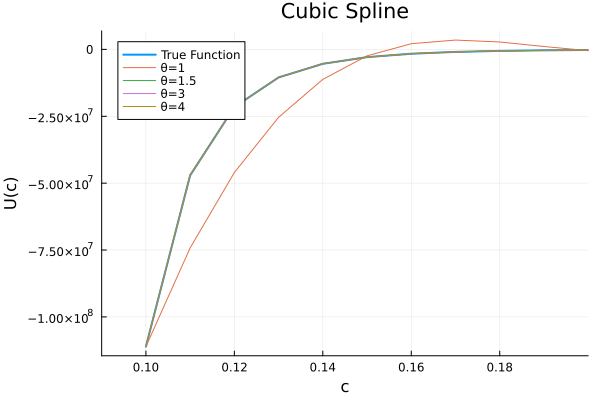

In [72]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(xlim=[0.09,0.2])

Chebyshev interpolation:

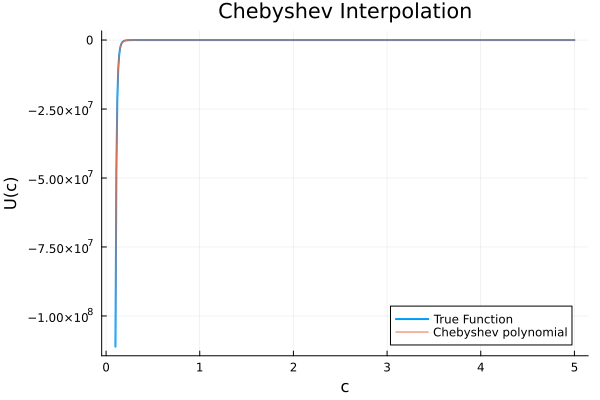

In [73]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")

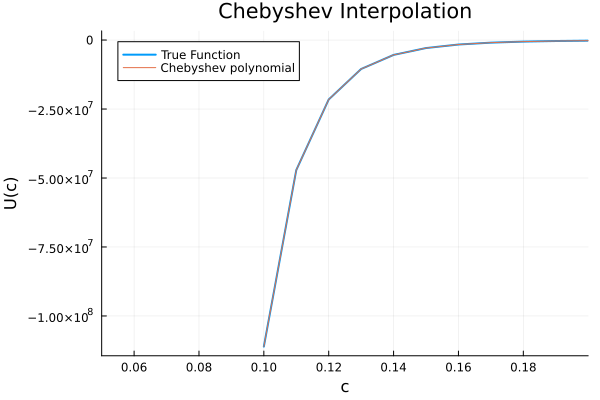

In [74]:
cfine = 0.1:0.01:5 # 0.01 increment
plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Chebyshev Interpolation",lw=2)
plot!(cfine,cheb_interp.(cfine),label="Chebyshev polynomial")
plot!(xlim=[0.05,0.2])

Compute errors using the sup norm:

$\theta=1$:

In [75]:
diff_linear = norm(linear_interp[1](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[1](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:4.54784553766e7
Error of cubic interpolation:2.711104099514702e7
Error of Chebyshev interpolation:6.876303944271058


$\theta=1.5$:

In [76]:
diff_linear = norm(linear_interp[2](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[2](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:3.663049042448312e6
Error of cubic interpolation:213157.10909917206
Error of Chebyshev interpolation:6.876303944271058


$\theta=3$:

In [77]:
diff_linear = norm(linear_interp[3](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[3](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:211172.64788009226
Error of cubic interpolation:414.2483859080821
Error of Chebyshev interpolation:6.876303944271058


$\theta=4$:

In [78]:
diff_linear = norm(linear_interp[4](cfine) - u3(α,cfine),Inf)
diff_cubic = norm(cubic_interp[4](cfine) - u3(α,cfine),Inf)
diff_cheb = norm(cheb_interp.(cfine) - u3(α,cfine),Inf)

println("Error of linear interpolation:", diff_linear)
println("Error of cubic interpolation:", diff_cubic)
println("Error of Chebyshev interpolation:", diff_cheb)

Error of linear interpolation:132287.87144924328
Error of cubic interpolation:203.09650538116693
Error of Chebyshev interpolation:6.876303944271058


Now the errors are even larger for all interpolation methods. Note also that the CRRA with RRA=10 is one of the cases available in Fatih's slides. If we use an interactive plot, we can see the huge fluctuations when $\theta=1$:

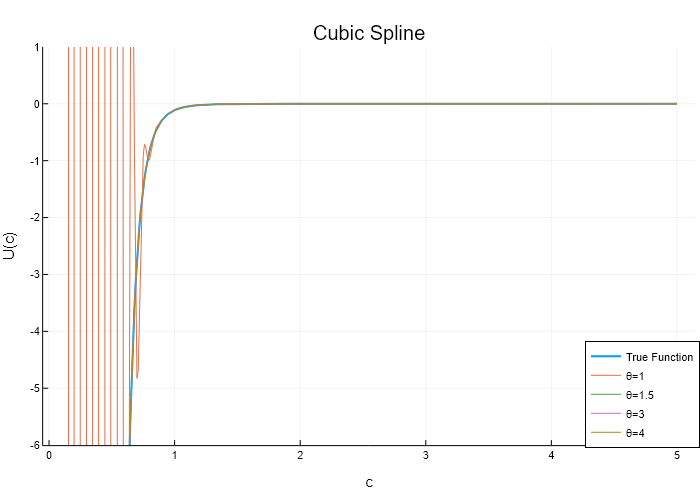

In [122]:
cfine = 0.1:0.01:5 # 0.01 increment
plotlyjs()
p=plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Cubic Spline",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="θ=1")
plot!(cfine,cubic_interp[2](cfine),label="θ=1.5")
plot!(cfine,cubic_interp[3](cfine),label="θ=3")
plot!(cfine,cubic_interp[4](cfine),label="θ=4")
plot!(ylim=[-6,1])
plot!(legend=:bottomright)
savefig(p, "plot.png")

img = Images.load("plot.png") 
display(img)

Let's plot a similar graph, but with all interpolation methods and $\theta=1$:

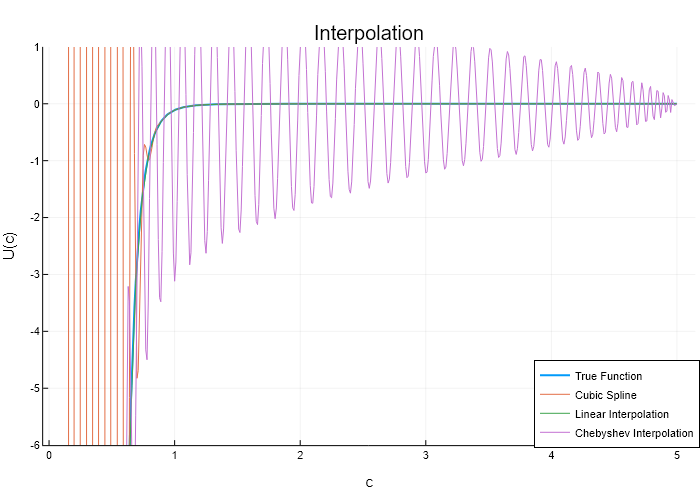

In [123]:
cfine = 0.1:0.01:5 # 0.01 increment
plotlyjs()
p2=plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Interpolation",lw=2)
plot!(cfine,cubic_interp[1](cfine),label="Cubic Spline")
plot!(cfine,linear_interp[1](cfine),label="Linear Interpolation")
plot!(cfine,cheb_interp.(cfine),label="Chebyshev Interpolation")
plot!(ylim=[-6,1])
plot!(legend=:bottomright)
savefig(p2, "plot2.png")
img2 = Images.load("plot2.png") 
display(img2)

Since the utility function has a pole at zero, it's very difficult to interpolate at the low end.
Potential solution: put more points where the function has more curvature. This is exactly what the expanding grid is doing. When we increase $\theta$, we are putting even more points near the low end of the grid. Note that with $\theta=4$, the behavior is improved:

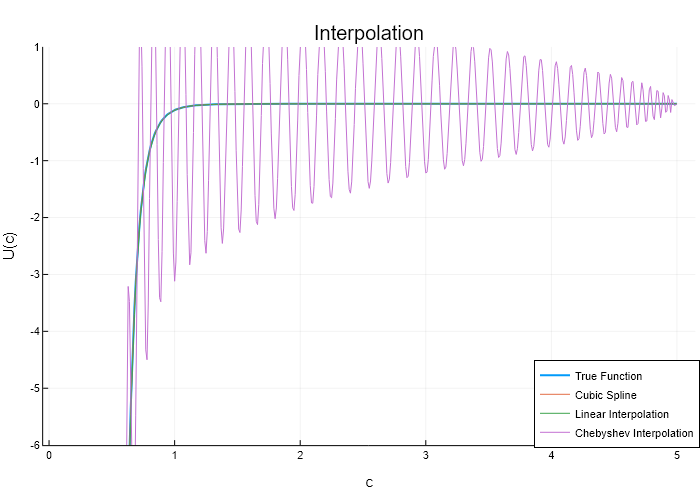

In [124]:
cfine = 0.1:0.01:5 # 0.01 increment
plotlyjs()
p3=plot(cfine,u3(α,cfine),label="True Function",xlabel="c",ylabel="U(c)",title="Interpolation",lw=2)
plot!(cfine,cubic_interp[4](cfine),label="Cubic Spline")
plot!(cfine,linear_interp[4](cfine),label="Linear Interpolation")
plot!(cfine,cheb_interp.(cfine),label="Chebyshev Interpolation")
plot!(ylim=[-6,1])
plot!(legend=:bottomright)
savefig(p3, "plot3.png")

img3 = Images.load("plot3.png") 
display(img3)

### Item (b)

Since the Chebyshev polynomials are defined only over the domain, they don't allow us to extrapolate. Thus, extrapolation is only feasible for linear interpolation and cubic spline.

I use $\theta=3$ for this item.

I will start with $u(c) = \log(c)$.

In [82]:
pts = 100
lb = 0.1
ub = 5
θ=3
grid = expanding_grid(lb,ub,pts,θ)
linear_interp = Vector{Spline1D}(undef, 1)
cubic_interp = Vector{Spline1D}(undef, 1)
linear_interp =  Spline1D(grid,u1(grid),k=1,bc="extrapolate")
cubic_interp =  Spline1D(grid,u1(grid),k=3,bc="extrapolate")

Spline1D(knots=[0.1,0.100039 … 4.71184,5.0] (99 elements), k=3, extrapolation="extrapolate", residual=0.0)

Analyze them at $c \in \{0.05,5.1,5.5,6\}$:

In [83]:
c_vec = [0.05, 5.1, 5.5, 6]
linear_extrapolation_log = Vector{Float64}(undef,4)
cubic_extrapolation_log = Vector{Float64}(undef,4)
for i=1:length(c_vec)
    linear_extrapolation_log[i] = linear_interp(c_vec[i])
    cubic_extrapolation_log[i] = cubic_interp(c_vec[i])
end

Now I do the same for $u(c) = \sqrt{c}$:

In [84]:
pts = 100
lb = 0.1
ub = 5
θ=3
grid = expanding_grid(lb,ub,pts,θ)
linear_interp = Vector{Spline1D}(undef, 1)
cubic_interp = Vector{Spline1D}(undef, 1)
linear_interp =  Spline1D(grid,u2(grid),k=1,bc="extrapolate")
cubic_interp =  Spline1D(grid,u2(grid),k=3,bc="extrapolate")

c_vec = [0.05, 5.1, 5.5, 6]
linear_extrapolation_sqrt = Vector{Float64}(undef,4)
cubic_extrapolation_sqrt = Vector{Float64}(undef,4)
for i=1:length(c_vec)
    linear_extrapolation_sqrt[i] = linear_interp(c_vec[i])
    cubic_extrapolation_sqrt[i] = cubic_interp(c_vec[i])
end

Now CRRA with $\alpha=2$:

In [85]:
pts = 100
lb = 0.1
ub = 5
θ=3
grid = expanding_grid(lb,ub,pts,θ)
α=2
linear_interp = Vector{Spline1D}(undef, 1)
cubic_interp = Vector{Spline1D}(undef, 1)
linear_interp =  Spline1D(grid,u3(α,grid),k=1,bc="extrapolate")
cubic_interp =  Spline1D(grid,u3(α,grid),k=3,bc="extrapolate")

c_vec = [0.05, 5.1, 5.5, 6]
linear_extrapolation_crra2 = Vector{Float64}(undef,4)
cubic_extrapolation_crra2 = Vector{Float64}(undef,4)
for i=1:length(c_vec)
    linear_extrapolation_crra2[i] = linear_interp(c_vec[i])
    cubic_extrapolation_crra2[i] = cubic_interp(c_vec[i])
end

CRRA with $\alpha=5$:

In [86]:
pts = 100
lb = 0.1
ub = 5
θ=3
grid = expanding_grid(lb,ub,pts,θ)
α=5
linear_interp = Vector{Spline1D}(undef, 1)
cubic_interp = Vector{Spline1D}(undef, 1)
linear_interp =  Spline1D(grid,u3(α,grid),k=1,bc="extrapolate")
cubic_interp =  Spline1D(grid,u3(α,grid),k=3,bc="extrapolate")

c_vec = [0.05, 5.1, 5.5, 6]
linear_extrapolation_crra5 = Vector{Float64}(undef,4)
cubic_extrapolation_crra5 = Vector{Float64}(undef,4)
for i=1:length(c_vec)
    linear_extrapolation_crra5[i] = linear_interp(c_vec[i])
    cubic_extrapolation_crra5[i] = cubic_interp(c_vec[i])
end

CRRA with $\alpha=10$:

In [87]:
pts = 100
lb = 0.1
ub = 5
θ=1
grid = expanding_grid(lb,ub,pts,θ)
α=10
linear_interp = Vector{Spline1D}(undef, 1)
cubic_interp = Vector{Spline1D}(undef, 1)
linear_interp =  Spline1D(grid,u3(α,grid),k=1,bc="extrapolate")
cubic_interp =  Spline1D(grid,u3(α,grid),k=3,bc="extrapolate")

c_vec = [0.05, 5.1, 5.5, 6]
linear_extrapolation_crra10 = Vector{Float64}(undef,4)
cubic_extrapolation_crra10 = Vector{Float64}(undef,4)
for i=1:length(c_vec)
    linear_extrapolation_crra10[i] = linear_interp(c_vec[i])
    cubic_extrapolation_crra10[i] = cubic_interp(c_vec[i])
end

Compute the true values at $c \in \{0.05,5.1,5.5,6\}$

In [88]:
c_vec = [0.05, 5.1, 5.5, 6]
true_log = Vector{Float64}(undef,4)
true_sqrt = Vector{Float64}(undef,4)
true_crra2 = Vector{Float64}(undef,4)
true_crra5 = Vector{Float64}(undef,4)
true_crra10 = Vector{Float64}(undef,4)

α1 = 2
α2 = 5
α3 = 10

for i = 1:length(c_vec)
    true_log[i] = u1(c_vec[i])
    true_sqrt[i] = u2(c_vec[i])
    true_crra2[i] = u3(α1,c_vec[i])
    true_crra5[i] = u3(α2,c_vec[i])
    true_crra10[i] = u3(α3,c_vec[i])
end

Compute the difference between true and extrapolated values using linear interpolation:

In [89]:
diff_log_linear = Vector{Float64}(undef,4)
diff_sqrt_linear = Vector{Float64}(undef,4)
diff_crra2_linear = Vector{Float64}(undef,4)
diff_crra5_linear = Vector{Float64}(undef,4)
diff_crra10_linear = Vector{Float64}(undef,4)

diff_log_linear = abs.(true_log - linear_extrapolation_log)
diff_sqrt_linear = abs.(true_sqrt - linear_extrapolation_sqrt)
diff_crra2_linear = abs.(true_crra2 - linear_extrapolation_crra2)
diff_crra5_linear = abs.(true_crra5 - linear_extrapolation_crra5)
diff_crra10_linear = abs.(true_crra10 - linear_extrapolation_crra10);

Compute the difference between true and extrapolated values using cubic spline:

In [90]:
diff_log_cubic = Vector{Float64}(undef,4)
diff_sqrt_cubic = Vector{Float64}(undef,4)
diff_crra2_cubic = Vector{Float64}(undef,4)
diff_crra5_cubic = Vector{Float64}(undef,4)
diff_crra10_cubic = Vector{Float64}(undef,4)

diff_log_cubic = abs.(true_log - cubic_extrapolation_log)
diff_sqrt_cubic = abs.(true_sqrt - cubic_extrapolation_sqrt)
diff_crra2_cubic = abs.(true_crra2 - cubic_extrapolation_crra2)
diff_crra5_cubic = abs.(true_crra5 - cubic_extrapolation_crra5)
diff_crra10_cubic = abs.(true_crra10 - cubic_extrapolation_crra10);

Set up a table comparing the results:

In [91]:
values_linear = hcat(c_vec, diff_log_linear, diff_sqrt_linear, diff_crra2_linear, diff_crra5_linear, diff_crra10_linear)
header_linear = ["Consumption", "log(c)", "sqrt(c)", "CRRA with α=2", "CRRA with α=5", "CRRA with α=10"]

pretty_table(values_linear, header=header_linear, 
    title = "Absolute difference of LINEAR interpolation and true values",
    border_crayon=crayon"bold yellow", tf=tf_simple)

 println("-"^90)  # separator = 70 dashes

values_cubic = hcat(c_vec, diff_log_cubic, diff_sqrt_cubic, diff_crra2_cubic, diff_crra5_cubic, diff_crra10_cubic)
header_cubic = ["Consumption", "log(c)", "sqrt(c)", "CRRA with α=2", "CRRA with α=5", "CRRA with α=10"]

pretty_table(values_cubic, header=header_cubic, 
    title = "Absolute difference of CUBIC interpolation and true values",
    border_crayon=crayon"bold yellow", tf=tf_simple)

Absolute difference of LINEAR interpolation and true values
============== ============= ============= =============== =============== =================
  Consumption        log(c)       sqrt(c)   CRRA with α=2   CRRA with α=5   CRRA with α=10  
============== ============= ============= =============== =============== =================
         0.05      0.193159      0.013565         5.00024         32500.6       5.66675e10  
          5.1   0.000494217   0.000275824      0.00019835      4.00952e-6       1.47352e-9  
          5.5    0.00617404    0.00348912      0.00241777      4.55622e-5       2.10392e-8  
          6.0     0.0206469     0.0118363      0.00786585     0.000137615       6.17399e-8  
============== ============= ============= =============== =============== =================
------------------------------------------------------------------------------------------
Absolute difference of CUBIC interpolation and true values
============== ============= ============= ===

I am comparing both interpolation methods by checking the absolute distance between the extrapolated values and the true function evaluated at the same points. The tables show that extrapolating with cubic splines generates smaller deviations from the true value than extrapolating with linear splines. Moreover, as expected, the extrapolation error increases as we move farther from the grid, regardless of the interpolation method used.

---
## Question (2)

Create a vector for $\epsilon$:

In [92]:
ϵ = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10];
# I tried using a loop to be quicker but I was getting weird decimal places

10-element Vector{Float64}:
 0.1
 0.01
 0.001
 0.0001
 1.0e-5
 1.0e-6
 1.0e-7
 1.0e-8
 1.0e-9
 1.0e-10

Create the function and its derivative:

In [93]:
g(p) = 0.5*p^(-0.5) + 0.5*p^(-0.2); # function
dg(p) = 0.5*(-0.5)*p^(-1.5) + 0.5*(-0.2)*p^(-1.2); # true derivative

Compute the true derivative at $p=1.5$:

In [94]:
true_deriv = dg(1.5);
println("The true derivative at p=1.5 is: ", true_deriv)

The true derivative at p=1.5 is: -0.19755662425340287


From the slides, we have that one-sided finite differences is given by $$f^\prime(x) = \lim_{h\rightarrow 0}\frac{f(x+h)-f(x)}{h}$$ while the two-sided finite differences is given by $$f^\prime(x) = \lim_{h\rightarrow 0}\frac{f(x+h)-f(x-h)}{2h}$$

### Item (a)

Note that in our case, $h = \epsilon$.

In [95]:
# Create a vector to store the one-sided numerical derivative:
nd1 = zeros(length(ϵ));
p = 1.5; # point we are interested in 

# To avoid repetition in the loop, compute g(p=1.5):
g_val = g(p);

for i = 1:length(ϵ)
    nd1[i] = (g(p+ϵ[i]) - g_val)/ϵ[i];
end

Compute the difference from the true derivative:

In [96]:
diff_1 = nd1 .- true_deriv

10-element Vector{Float64}:
  0.008791744981808292
  0.0009213553229910354
  9.258113213800323e-5
  9.262594513226308e-6
  9.2630840739516e-7
  9.26752448671131e-8
  9.852607230076416e-9
  8.742384205451259e-9
 -1.3462076287051872e-8
  2.0858252863797944e-7

Get the $\epsilon$ for which the numerical first derivative is most accurate:

In [97]:
idx = findmin(abs.(diff_1))[2]
println("The value of ϵ for which the one-sided numerical first derivative is most accurate is: ", ϵ[idx])

The value of ϵ for which the one-sided numerical first derivative is most accurate is: 1.0e-8


### Item (b)

Now I do the same, but for two-sided finite differences:

In [98]:
# Create a vector to store the one-sided numerical derivative:
nd2 = zeros(length(ϵ));

for i = 1:length(ϵ)
    nd2[i] = (g(p+ϵ[i]) - g(p-ϵ[i]))/(2*ϵ[i]);
end

Compute the difference from the true derivative:

In [99]:
diff_2 = nd2 .- true_deriv

10-element Vector{Float64}:
 -0.000499911551227028
 -4.982400475916915e-6
 -4.982237994388683e-8
 -4.985571400162314e-10
 -6.1732008393988735e-12
 -2.837768908747762e-11
 -1.3939999154999327e-10
  3.1912690823254763e-9
 -1.3462076287051872e-8
 -3.4652898367459883e-7

Get the $\epsilon$ for which the numerical first derivative is most accurate:

In [100]:
idx2 = findmin(abs.(diff_2))[2]
println("The value of ϵ for which the two-sided numerical first derivative is most accurate is: ", ϵ[idx2])

The value of ϵ for which the two-sided numerical first derivative is most accurate is: 1.0e-5


Comparing with the result in item (a), we can conclude two things: 

1. The two-sided numerical difference is more precise than the one-sided;
2. This higher precision is achieved with a lower $\epsilon$.

---
## Question (3)

### Item (a)

#### Bisection:

Note that finding $p_0$ such that $g(p_0) = 0.75$ is the same as finding $p_0$ such that $f(p_0) \equiv g(p_0)-0.75 = 0$. That is, we need to find the root of $f$.

Define function $f$:

In [101]:
f(p) = g(p) - 0.75

f (generic function with 1 method)

I'll create my own function for the bisection method:

In [102]:
function bisection(a,b,f,tol=1e-6)

    if f(a)*f(b) > 0
        error("The function must have opposite signs at the endpoints.")
    end

    dif = 1 # initialize dif
    iter = 0 # iterations counter
    c = 1 # initialize a value for c
    fc = f(c) # initialize a value for fc
    while dif > tol 
        c = (a+b)/2 # compute the midpoint
        fc = f(c) # evaluate the function at c

        if fc*f(a) > 0
            a = c
        elseif fc*f(b) > 0
            b = c 
        end
        # convergence rule is |f(p^)-f(p0)| < tol but note that f(p0) = 0, so:
        dif = abs(fc)
        # update iter
        iter += 1
    end
    return c, fc, iter
end

bisection (generic function with 2 methods)

Note that:

In [103]:
f(2.5)

-0.01749563028222556

and: 

In [104]:
f(2.3)

0.00296700930148619

So the root for $f$ must lie in the interval $(2.3,2.5)$. Thus, I use those as starting points.

In [105]:
a = 2.3
b = 2.5
root_bis, froot_bis, iter_bis = bisection(a,b,f);
println("The solution from the bisection method is: ", root_bis)
println("The function f evaluated at this solution is: ", froot_bis)
println("The algorithm converged to a solution in ", iter_bis, " iterations.")

The solution from the bisection method is: 2.327587890625
The function f evaluated at this solution is: -8.26928810870875e-7
The algorithm converged to a solution in 12 iterations.


Now using the `bisection` function from the `Roots` package:

In [106]:
root_bis2 = find_zero(f, (a, b), Bisection(); atol=1e-6, verbose=true)

Results of univariate zero finding:

* Converged to: 2.327587890624999
* Algorithm: Bisection()
* iterations: 11
* function evaluations ≈ 14
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
(a₀, b₀) = ( 2.2999999999999998, 2.3999999999999999 )
(a₁, b₁) = ( 2.2999999999999998, 2.3499999999999996 )
(a₂, b₂) = ( 2.3249999999999997, 2.3499999999999996 )
(a₃, b₃) = ( 2.3249999999999997, 2.3374999999999995 )
(a₄, b₄) = ( 2.3249999999999997, 2.3312499999999994 )
(a₅, b₅) = ( 2.3249999999999997, 2.3281249999999996 )
(a₆, b₆) = ( 2.3265624999999996, 2.3281249999999996 )
(a₇, b₇) = ( 2.3273437499999994, 2.3281249999999996 )
(a₈, b₈) = ( 2.3273437499999994, 2.3277343749999995 )
(a₉, b₉) = ( 2.3275390624999992, 2.3277343749999995 )
(a₁₀, b₁₀) = ( 2.3275390624999992, 2.3276367187499991 )
(a₁₁, b₁₁) = ( 2.3275390624999992, 2.3275878906249989 )



2.327587890624999

Note that both solutions are very close to each other:

In [107]:
println("The difference between the solutions is: ",root_bis2 - root_bis)

The difference between the solutions is: -8.881784197001252e-16


Even though the solutions are very close to each other, note that my algorithm required 12 iterations to reach a solution, while the `Bisection` function from the `Roots` package needed 11 iterations. This difference could be due to several factors, including how both codes update the iterations.

#### Secant's method:

I use the `secant` function from the `Roots` package:

In [108]:
# Use the secant method with tolerance
# Order1 == secant method
# verbose=true prints details
root_secant = find_zero(f, (a, b), Order1(); atol=1e-6, verbose=true)

Results of univariate zero finding:

* Converged to: 2.3275801706034356
* Algorithm: Secant()
* iterations: 3
* function evaluations ≈ 5
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
x₁ = 2.2999999999999998,	 fx₁ = 0.0029670093014861898
x₂ = 2.5,	 fx₂ = -0.01749563028222556
x₃ = 2.3289992822221031,	 fx₃ = -0.00015133762954999685
x₄ = 2.3275072154196059,	 fx₄ = 7.7801241558095313e-06
x₅ = 2.3275801706034356,	 fx₅ = -3.3154290424164401e-09



2.3275801706034356

In [109]:
println("The solution from the secant's method is: ", root_secant)
println("The function f evaluated at this solution is: ", f(root_secant))
println("The algorithm converged to a solution in ", 3, " iterations.")

The solution from the secant's method is: 2.3275801706034356
The function f evaluated at this solution is: -3.31542904241644e-9
The algorithm converged to a solution in 3 iterations.


#### Newton-Raphson's method:

I use the `Newton` function from the `Roots` package.

Note that the derivative of $f$ has the same expression as the derivative of $g$.

In [110]:
df = dg;

root_newton = find_zero((f,df), b, Roots.Newton(); verbose=true, atol=1e-6)

Results of univariate zero finding:

* Converged to: 2.327580139364695
* Algorithm: Roots.Newton()
* iterations: 3
* function evaluations ≈ 6
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
x₁ = 2.5,	 fx₁ = -0.01749563028222556
x₂ = 2.3187876703975894,	 fx₂ = 0.00094051438913245189
x₃ = 2.3275569051955429,	 fx₃ = 2.4787863908137808e-06
x₄ = 2.3275801393646951,	 fx₄ = 1.7295276322215614e-11



2.327580139364695

In [111]:
println("The solution from the Newton's method is: ", root_newton)
println("The function f evaluated at this solution is: ", f(root_newton))
println("The algorithm converged to a solution in ", 3, " iterations.")

The solution from the Newton's method is: 2.327580139364695
The function f evaluated at this solution is: 1.7295276322215614e-11
The algorithm converged to a solution in 3 iterations.


### Item (b)

I used the `Brent` function from the `Roots` package in Julia:

In [112]:
root_brent = find_zero(f, (a, b), Roots.Brent(); atol=1e-6, verbose=true)

Results of univariate zero finding:

* Converged to: 2.327580139491457
* Algorithm: Roots.Brent()
* iterations: 3
* function evaluations ≈ 5
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
(a₀, b₀) = ( 2.2999999999999998, 2.5 )
(a₁, b₁) = ( 2.2999999999999998, 2.3289992822221031 )
(a₂, b₂) = ( 2.2999999999999998, 2.3275919075049205 )
(a₃, b₃) = ( 2.3275801394914568, 2.3275919075049205 )



2.327580139491457

In [113]:
println("The solution from the Brent's method is: ", root_brent)
println("The function f evaluated at this solution is: ", f(root_brent))
println("The algorithm converged to a solution in ", 3, " iterations.")

The solution from the Brent's method is: 2.327580139491457
The function f evaluated at this solution is: 3.771649659256582e-12
The algorithm converged to a solution in 3 iterations.


Now, I'll compare the time it takes to find the solution for all the algorithms I am using. To this end, I use the `BenchmarkTools` package in Julia, which allows me to precisely apply the hint mentioned in the question by controlling the number of samples (repetitions of the benchmark) and evaluations (executions of the code within each sample).

I set samples = 10 and evals = 100.

Bisection:

In [114]:
t_bis = @benchmark find_zero(f, (a, b), Bisection(); atol=1e-6) samples = 10 evals = 100

BenchmarkTools.Trial: 10 samples with 100 evaluations per sample.
 Range (min … max):  1.296 μs …  1.463 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.351 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.368 μs ± 66.497 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  █ ▁ ▁                      ▁           █           ▁  ▁  
  █▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  1.3 μs         Histogram: frequency by time        1.46 μs <

 Memory estimate: 256 bytes, allocs estimate: 8.

Note that `t_bis.times` is a 10-entry vector. Each entry represents the total time it took the code to run in a sample.

In [115]:
t_bis.times

10-element Vector{Float64}:
 1463.0
 1454.0
 1318.0
 1307.0
 1307.0
 1418.0
 1313.0
 1383.0
 1418.0
 1296.0

In [116]:
t_sec = @benchmark find_zero(f, (a, b), Order1(); atol=1e-6) samples = 10 evals = 100

BenchmarkTools.Trial: 10 samples with 100 evaluations per sample.
 Range (min … max):  567.000 ns … 997.000 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     584.500 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   657.200 ns ± 164.019 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   ▂                                                          
  █▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▅ ▁
  567 ns           Histogram: frequency by time          997 ns <

 Memory estimate: 144 bytes, allocs estimate: 5.

In [117]:
t_newton = @benchmark find_zero((f,df), b, Roots.Newton(); atol=1e-6) samples = 10 evals = 100

BenchmarkTools.Trial: 10 samples with 100 evaluations per sample.
 Range (min … max):  411.000 ns … 556.000 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     414.000 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   436.200 ns ±  45.701 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                                                             
  ██▁▁▁▁▁▆▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  411 ns           Histogram: frequency by time          556 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [118]:
t_brent = @benchmark find_zero(f, (a, b), Roots.Brent(); atol=1e-6) samples = 10 evals = 100

BenchmarkTools.Trial: 10 samples with 100 evaluations per sample.
 Range (min … max):  1.019 μs …  1.181 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.057 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.065 μs ± 45.809 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▁     ▁  ▁  █ ▁  ▁     ▁                                ▁  
  ██▁▁▁▁▁█▁▁█▁▁█▁█▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.02 μs        Histogram: frequency by time        1.18 μs <

 Memory estimate: 304 bytes, allocs estimate: 8.

Compute total time:

In [119]:
total_bis = 0
total_sec = 0
total_newton = 0
total_brent = 0

for i = 1:10 
    total_bis += t_bis.times[i]
    total_sec += t_sec.times[i]
    total_newton += t_newton.times[i]
    total_brent += t_brent.times[i]
end

# Transform time from nanoseconds to seconds:
total_bis = total_bis/1e6
total_sec = total_sec/1e6
total_newton = total_newton/1e6
total_brent = total_brent/1e6;

Construct a table: 

In [120]:
method = ["Bisection", "Secant", "Newton-Raphson", "Brent"]
time = [total_bis,total_sec,total_newton,total_brent]
data = hcat(method,time)
header = ["Method", "Total time (ms)"]

table = pretty_table(data,header = header,border_crayon=crayon"bold yellow",tf=tf_simple)

================= ==================
          Method   Total time (ms)  
================= ==================
       Bisection          0.013677  
          Secant          0.006572  
  Newton-Raphson          0.004362  
           Brent          0.010646  
================= ==================
